In [1]:
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from skimage import io
from skimage.util import img_as_ubyte
from skimage.exposure import histogram
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.feature import canny

#### Select  mask parameters

In [2]:
mask_channel = 0
mask_time = 0

In [3]:
img_dir = "/Users/gonzalovidal/Gonzalo/Synthetic Biology/Corchea/gro1/T1" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
for f1 in files:
    imraw = io.imread(f1)
    data.append(imraw)
np_data = np.array(data)

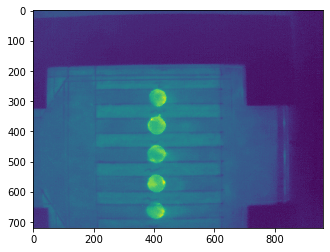

In [4]:
im = np_data[mask_time,:,:,mask_channel]
#Obtain the channel as ubyte
image = img_as_ubyte(im)
plt.imshow(image)

#### MASK Segmentation algorithm

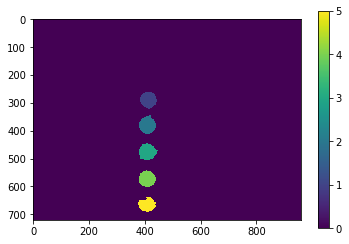

In [5]:
hist, hist_centers = histogram(im)
edges = canny(im/255.)
fill_im = ndi.binary_fill_holes(edges) 
label_objects, nb_labels = ndi.label(edges)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 1
mask_sizes[0] = 0
im_cleaned = mask_sizes[label_objects]
markers = np.zeros_like(im)
markers[im < 30] = 1
markers[im > 100] = 2
elevation_map = sobel(im)
markers = np.zeros_like(im) 
markers[im < 30] = 1
markers[im > 100] = 2
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_discs, _ = ndi.label(segmentation)
plt.imshow(labeled_discs)
plt.colorbar()

#### Create Corchea_df and set the time

In [6]:
columns = {'Time':[],'Sample':[],'Value':[],'Name':[]}
Corchea_df = pd.DataFrame(columns)
time = np_data.shape[0]
Corchea_df

,Time,Sample,Value,Name


In [7]:
for t in range(time):   
    for disc in range(1,6): #the complement is the disc 0
        sample = labeled_discs==disc
        area = np.sum(sample)
        tfluo = np.sum(sample*im)
        avfluo = tfluo/area
        rfluo = np.sum(sample*np_data[time-1,:,:,0])
        ravfluo = rfluo/area
        gfluo = np.sum(sample*np_data[time-1,:,:,1])
        gavfluo = gfluo/area

        d_fluo_av = {'Time':t,'Sample':disc,'Value':avfluo,'Name':'fluo_av'}
        pd_fluo_av = pd.DataFrame([d_fluo_av]) 
        d_fluo_av_r = {'Time':t,'Sample':disc,'Value':ravfluo,'Name':'fluo_av_r'}
        pd_fluo_av_r = pd.DataFrame([d_fluo_av_r])
        d_fluo_av_g = {'Time':t,'Sample':disc,'Value':gavfluo,'Name':'fluo_av_g'}
        pd_fluo_av_g = pd.DataFrame([d_fluo_av_g])

        Corchea_df = Corchea_df.append(pd_fluo_av,ignore_index=True )
        Corchea_df = Corchea_df.append(pd_fluo_av_r,ignore_index=True )
        Corchea_df = Corchea_df.append(pd_fluo_av_g,ignore_index=True )

In [8]:
Corchea_df

,Time,Sample,Value,Name
0,0.0,1.0,118.818912,fluo_av
1,0.0,1.0,122.980650,fluo_av_r
2,0.0,1.0,49.290982,fluo_av_g
3,0.0,2.0,119.527676,fluo_av
4,0.0,2.0,123.666556,fluo_av_r
...,...,...,...,...
175,11.0,4.0,126.974250,fluo_av_r
176,11.0,4.0,48.868783,fluo_av_g
177,11.0,5.0,115.860303,fluo_av
178,11.0,5.0,119.716100,fluo_av_r


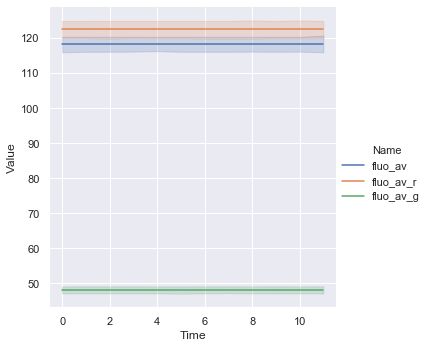

In [9]:
#sns.set()
sns.relplot(x="Time", y="Value",
            hue="Name",
            kind="line", data=Corchea_df);

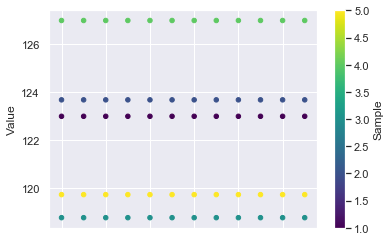

In [10]:
Corchea_df.loc[Corchea_df['Name'] == 'fluo_av_r'].plot.scatter(x='Time',
                      y='Value',
                      c='Sample',
                      colormap='viridis');

#### Done!